## Initialisation

### Dependencies

#### Third party

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

#### Personal notebook

Enter the value of engineering strain upto which the line seems linear (used in calculation of Youngs modulus) in the units same as in dataset: 0.01
Enter the value of engineering stress upto which the line seems linear (used in calculation of Youngs modulus) in the units same as in dataset: 200
Young's Modulus: 29.069165948552968 GPa
Yield Strength: 235.10488199999998 MPa
Ultimate Tensile Strength is 362.20079200000004 MPa at 18.095% elongation.


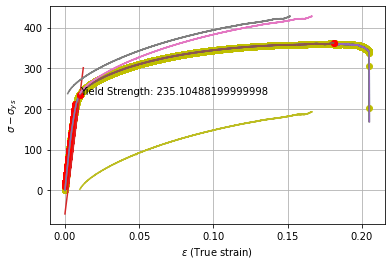

In [2]:
import ipynb

from ipynb.fs.full.dataset_initialisation import (
    OUTPUT_DIR,
)
from ipynb.fs.defs.utilities import (
    differentiate,
    save_parameter,
    save_fig,
)
from ipynb.fs.full.true_strain_stress import (
    true_plastic_strain,
    true_stress,
    true_strain,
)
from ipynb.fs.full.engineering_strain_stress import (
    yield_strength,
)

### Notations

- $\sigma \rightarrow$ True Stress
- $\epsilon \rightarrow$ True Strain
- $\epsilon_{pl} \rightarrow$ True Plastic Strain
- $\sigma_{ys} \rightarrow$ Yield Strength
- $\sigma_{uts} \rightarrow$ Ultimate Tensile Strength
- $n \rightarrow$ Work hardening Exponent
- $E \rightarrow$ Young's Modulus
- $K \rightarrow$ Strength Coefficient
- $e \rightarrow$ Engineering Strain
- $s \rightarrow$ Engineering Stress
- $\theta \rightarrow$ Work hardening rate
- $\sigma - \sigma_{ys} \rightarrow$ Flow Stress

## Fitting hollomon equation to true stress-true strain data

### Plot of $\epsilon$ v/s flow stress ($\sigma - \sigma_{ys}$)

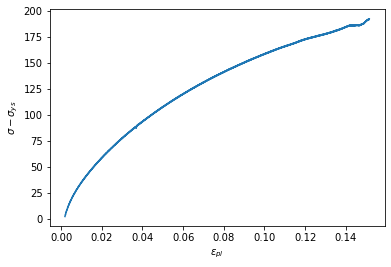

In [3]:
flow_stress = true_stress - yield_strength
_ = plt.plot(true_plastic_strain, flow_stress)
_ = plt.xlabel('$\epsilon_{pl}$')
_ = plt.ylabel('$\sigma - \sigma_{ys}$')

### Computing work hardening exponent

There are two ways to compute it:
1. Fitting hollomon equation to experimental data
2. Taking $ log $ on both sides of the hollomon equation

### Hollomon Equation

$ \sigma = K \cdot \epsilon^n $

#### Method 1

Do you want to provide initial guess for K and n? (Y/n): n
Strength coefficient (K): 627.0256735089662
Work hardening exponent (n): 0.21506122660509858


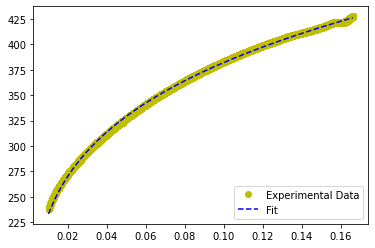

In [4]:
choose = input('Do you want to provide initial guess for K and n? (Y/n): ')

p0=None

if choose in ['Y', 'y']:
    initial_guess_n = float(input("Intial guess of work hardening exponent (0 < n < 1): "))
    initial_guess_K = float(input("Intial guess of strength coefficient (MPa): "))
    p0 = (initial_guess_K, initial_guess_n)
    
def fit_hollomon(x, K, n):
    return K*(x**n)

rhs_theoretical_hollomon = curve_fit(
    fit_hollomon, true_strain, true_stress, p0, method='lm',
)
popt, _ = rhs_theoretical_hollomon
K = popt[0]
n = popt[1]

_ = plt.plot(true_strain, true_stress, 'yo')
_ = plt.plot(true_strain, [fit_hollomon(pl,K,n) for pl in true_strain], 'b--')
if choose in ['Y', 'y']:
    _ = plt.plot(true_strain, [fit_hollomon(pl,initial_guess_K,initial_guess_n) for pl in true_strain], 'g:',)
    _ = plt.legend(['Experimental Data','Guess', 'Fit'], loc='lower right')

_ = plt.legend(['Experimental Data','Fit'], loc='lower right')

save_fig(plt, 'savefig', f'{OUTPUT_DIR}/Hollomon curve')

print(f'Strength coefficient (K): {K}')
print(f'Work hardening exponent (n): {n}')

save_parameter('Strength coefficient (K)', K, 'MPa', f'{OUTPUT_DIR}/output.txt')
save_parameter('Work hardening exponent (n)', n, '', f'{OUTPUT_DIR}/output.txt')

#### Method 2

$ \sigma = K \cdot \epsilon^n \Rightarrow $ 
$ log(\sigma) = logK + nlog\epsilon $

In [5]:
log_true_stress = np.log(true_stress)
log_true_strain = np.log(true_strain)

model = LinearRegression().fit(log_true_strain.reshape((-1,1)), log_true_stress)
coef = model.score(log_true_strain.reshape((-1,1)), log_true_stress)
work_hard_exp = model.coef_[0]
strenght_coefficient = np.exp(model.intercept_)
print(f'Work hardening exponent: {work_hard_exp}')
print(f'Strength coefficient: {strenght_coefficient}')
print(f'Accuracy in calculations: {coef}')

Work hardening exponent: 0.21339256831444006
Strength coefficient: 624.4083835301985
Accuracy in calculations: 0.9986865615752823


## Plot of $\frac{d\sigma}{d\epsilon}$ v/s $\epsilon$

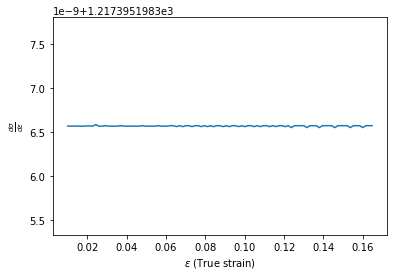

In [6]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

true_stress_smooth = smooth(true_stress,1)
# _ = plt.plot (true_strain, true_stress_smooth, 'bo')
# _ = plt.plot(true_strain, true_stress, color = 'yellow')

# Sir asked us to consider these number of points
consider = 100

reduced_true_strain = np.linspace(min(true_strain),max(true_strain),consider)
reduced_true_stress = np.linspace(min(true_stress),max(true_stress),consider)

d_sigma_epsilon = differentiate(reduced_true_strain, reduced_true_stress)

_ = plt.plot(reduced_true_strain[:consider-1], d_sigma_epsilon)
_ = plt.xlabel('$\epsilon$ (True strain)')
_ = plt.ylabel('$\\frac{d\sigma}{d\epsilon}$')

## Plot of $\frac{d\sigma}{d\epsilon}$ v/s $\frac{\sigma}{\epsilon}$

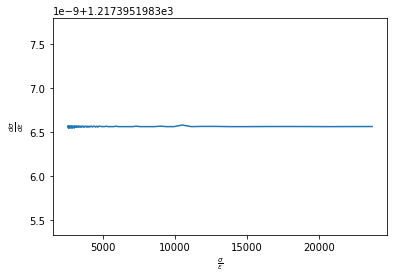

In [7]:
sigma_epsilon = np.true_divide(reduced_true_stress, reduced_true_strain)
_ = plt.plot(sigma_epsilon[:consider-1], d_sigma_epsilon)
_ = plt.xlabel('$\\frac{\sigma}{\epsilon}$')
_ = plt.ylabel('$\\frac{d\sigma}{d\epsilon}$')

## Plot $\frac{d\sigma}{d\epsilon}$ v/s $\sigma$

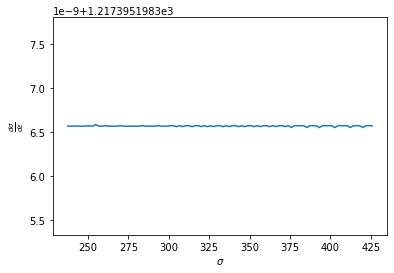

In [8]:
_ = plt.plot(reduced_true_stress[:consider-1], d_sigma_epsilon)
_ = plt.xlabel('$\sigma$')
_ = plt.ylabel('$\\frac{d\sigma}{d\epsilon}$')

## Plot of $\frac{d\sigma}{d\epsilon}$ v/s $\sigma - \sigma_{ys}$

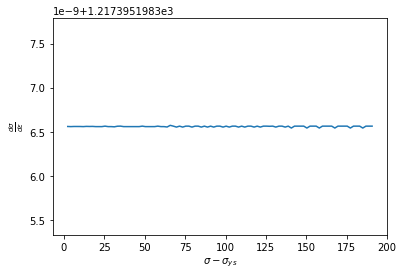

In [9]:
reduced_true_stress_ys = np.linspace(min(true_stress_smooth)-yield_strength,max(true_stress_smooth)-yield_strength,100)

d_sigma_epsilon = differentiate(reduced_true_strain, reduced_true_stress_ys)

_ = plt.plot(reduced_true_stress_ys[:consider-1], d_sigma_epsilon)
_ = plt.xlabel('$\sigma - \sigma_{ys}$')
_ = plt.ylabel('$\\frac{d\sigma}{d\epsilon}$')

## Plot of $\sigma - \sigma_{ys}$ v/s $\epsilon$

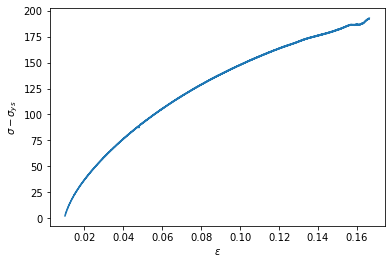

In [10]:
_ = plt.plot(true_strain, np.subtract(true_stress, yield_strength))
_ = plt.ylabel('$\sigma - \sigma_{ys}$')
_ = plt.xlabel('$\epsilon$')